In [8]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.titlesize'] = 18
matplotlib.rcParams['figure.figsize'] = [9, 7]
matplotlib.rcParams['font.family'] = ['KaiTi']
matplotlib.rcParams['axes.unicode_minus']=False

import  os
import  tensorflow as tf
import  numpy as np
from tensorflow.keras import layers, optimizers, Sequential, metrics

tf.random.set_seed(1234)
np.random.seed(1234)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

from load_dataset import load_data

In [19]:
def preprocess(x,y):
    # x: 图片的路径，y：图片的数字编码
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=1) # RGBA
    x = tf.image.resize(x, [28, 28])

#     x = tf.image.random_flip_left_right(x)
#     x = tf.image.random_flip_up_down(x)
#     x = tf.image.random_crop(x, [224,224,3])

    # x: [0,255]=> -1~1
    x = tf.cast(x, dtype=tf.float32) / 255.
    y = tf.convert_to_tensor(y)
    y = tf.one_hot(y, depth=10)

    return x, y

In [40]:
batchsz = 1024
# 创建训练集Datset对象
images, labels, table = load_data('4_Png',mode='train')
db_train = tf.data.Dataset.from_tensor_slices((images, labels))
db_train = db_train.map(preprocess).batch(batchsz).repeat(10)
# 创建验证集Datset对象
images2, labels2, table = load_data('4_Png',mode='val')
db_val = tf.data.Dataset.from_tensor_slices((images2, labels2))
db_val = db_val.map(preprocess).batch(batchsz).repeat(10)
# 创建测试集Datset对象
images3, labels3, table = load_data('4_Png',mode='test')
db_test = tf.data.Dataset.from_tensor_slices((images3, labels3))
db_test = db_test.map(preprocess).batch(batchsz).repeat(10)

In [41]:
db_test

<RepeatDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

In [44]:
from tensorflow import keras

cnn_layers = [
    layers.Conv2D(32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same'),
    layers.Conv2D(64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(1024, activation=tf.nn.relu),
    layers.Dense(10, activation=tf.nn.softmax)
]

model = Sequential(cnn_layers)
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), 
             metrics=[keras.metrics.CategoricalAccuracy()])
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           multiple                  832       
_________________________________________________________________
max_pooling2d_12 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_13 (Conv2D)           multiple                  51264     
_________________________________________________________________
max_pooling2d_13 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_6 (Flatten)          multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  3212288   
_________________________________________________________________
dense_13 (Dense)             multiple                 

In [46]:
history = model.fit(db_train, epochs=10, steps_per_epoch=90, validation_data=db_val, validation_steps=50)

Train for 90 steps, validate for 50 steps
Epoch 1/10
90/90 [==============================] - 21s 234ms/step - loss: 0.2644 - categorical_accuracy: 0.8975 - val_loss: 0.1327 - val_categorical_accuracy: 0.9372
Epoch 2/10
90/90 [==============================] - 20s 226ms/step - loss: 0.1151 - categorical_accuracy: 0.9458 - val_loss: 0.1283 - val_categorical_accuracy: 0.9363
Epoch 3/10
90/90 [==============================] - 20s 225ms/step - loss: 0.0907 - categorical_accuracy: 0.9568 - val_loss: 0.0825 - val_categorical_accuracy: 0.9624
Epoch 4/10
90/90 [==============================] - 20s 226ms/step - loss: 0.0755 - categorical_accuracy: 0.9649 - val_loss: 0.0697 - val_categorical_accuracy: 0.9676
Epoch 5/10
90/90 [==============================] - 20s 227ms/step - loss: 0.0660 - categorical_accuracy: 0.9702 - val_loss: 0.0605 - val_categorical_accuracy: 0.9730
Epoch 6/10
90/90 [==============================] - 20s 225ms/step - loss: 0.0589 - categorical_accuracy: 0.9732 - val_loss

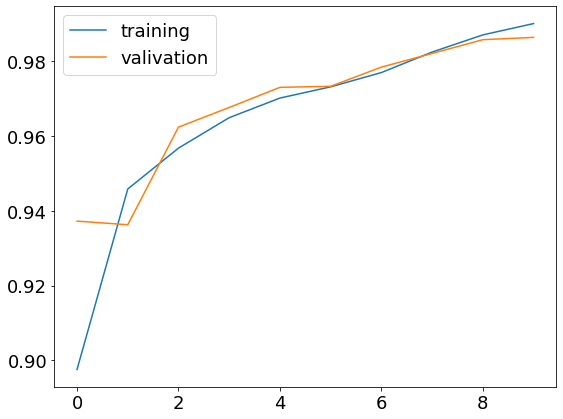

In [51]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt.show()

In [50]:
res = model.evaluate(db_test)

360/360 [==============================] - 52s 145ms/step - loss: 0.0316 - categorical_accuracy: 0.9872


In [54]:
model.metrics_names

['loss', 'categorical_accuracy']